# Demo
这是一个利用机器学习和深度学习深度学习方法，通过混凝土梁的基本参数预测其剪切承载力的demo笔记

In [82]:
# 导入主要的包
# pytorch相关
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# TensorDataset和DataLoader是pytorch定义的一种数据集类，可以比较方便地处理数据

# 辅助包，其中os（文件读取）,math（数学运算）,random（随机数）,sklearn（机器学习相关）一般由python自带
# pandas, matplotlib可通过pip或conda安装
# pip 安装（请在anaconda prompt shell里运行）：
# pip install pandas
# pip install matplotlib
# conda 安装（请在anaconda prompt shell里运行）：
# conda install pandas
# conda install matplotlib
import os
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR                             # 支持向量机SVM方法
from sklearn.metrics import r2_score

# 如果有gpu，优先加载到gpu上进行训练
device = torch.device('cpu')

In [59]:
# 数据前处理和后处理
def data_preprocess(input_data, ref):
    """
    在这里定义对数据进行预处理的函数
    简化为除以ref的形式，也可以采用更复杂的方式
    参数:
        input_data(nn.Tensor)
    输出:
        output_data(nn.Tensor)
    """
    output_data = input_data / ref
    return output_data

def data_postprocess(input_data, ref):
    """
    在这里定义对数据进行后处理的函数，即还原到原始数据的分布
    参数:
        input_data(nn.Tensor)
    输出:
        output_data(nn.Tensor)
    """
    output_data = input_data * ref
    return output_data

# 构建数据集, 数据集是一批混凝土剪切梁的基本信息和剪切承载力，保存为csv格式
# csv文件里的每行是一条数据，其中前11列是梁的静态特征参数（参见讲义），最后1列是需要预测的剪切承载力
# 共774条数据，第一次试验时建议不要修改以下参数，跑通模型后再自己尝试调整
"""
主要参数说明
DATA_SIZE: 总数据量，最大为774
TRAIN_SIZE: 训练集数据量，不超过总数据量
TEST_SIZE: 测试集数据量，除了训练数据以外的数据
SRC_SIZE: 输入特征维度，考虑11个特征参数因此取11，有兴趣的读者也可以研究取其中一部分参数的影响
TGT_SIZE: 输出特征维度，只预测剪切承载力数值，因此取1
input_ref: 输入特征的归一化参考值
output_ref: 输出特征的归一化参考值
data_path: csv数据存放路径，默认为脚本同一目录下的r'data/beam_data.csv'，为无箍筋梁的数据文件
注意BATCH_SIZE和SEQ_LEN一般受到显存的限制，需要根据配置调整
"""
DATA_SIZE = 640
TRAIN_SIZE = 608 
TEST_SIZE = DATA_SIZE - TRAIN_SIZE
SRC_SIZE = 9
TGT_SIZE = 1

# 输入特征的参考值，这里根据数据取每个特征维度的较大值
src_ref = torch.tensor([1000.0, 1000.0, 1000.0, 3.0, 10000, 50, 3.5, 400.0, 1000.0])
tgt_ref = 500.0
data_path = r'data/beam_data.csv' # 无箍筋梁的数据文件

def read_data(data_path=data_path):
    """
    请在这里定义一个函数，读取CSV文件中DATA_SIZE行的数据并转化为张量
    其中输入特征存储到srcs中，输出特征存储到tgts中
    参数：
        data_path(str):csv文件的存放路径，默认为“data/beam_data1”
    输出：
        srcs(nn.Tensor):输入特征张量，要求形状为(DATA_SIZE, SRC_SIZE)
        tgts(nn.Tensor):输出特征张量，即剪切承载力，要求形状为(DATA_SIZE, TGT_SIZE)
    提示：
        使用pandas的模块读取csv文件的数据为numpy的array，注意去除
        再将array转化为tensor
    """
    # 读取CSV文件，忽略第一行表头，保存为pandas的data_frame格式
    df = pd.read_csv(data_path, header=None, skiprows=1)
    
    # 请修改问号为合适的值
    ##### your code here #####
    src_array = df.iloc[:, 0:8]
    tgt_array = df.iloc[:, [9]]
    
    # 转化为张量, 数据格式为torch.float32
    return src_array, tgt_array

In [60]:
# 读取数据分别为numpy的array格式（机器学习）和pytorch的tensor格式（深度学习）
src_array, tgt_array = read_data(data_path)    
srcs, tgts = torch.tensor(src_array.values, dtype=torch.float32), torch.tensor(tgt_array.values, dtype=torch.float32)

# 数据预处理，做简单的归一化
srcs = (srcs - srcs.min()) / (srcs.max() - srcs.min())
tgts = (tgts - tgts.min()) / (tgts.max() - tgts.min())

# 检查读取数据的size，如果前后一致表明读取正确
print(f"srcs的shape: {srcs.shape}, 期望的shape: [{DATA_SIZE}, {SRC_SIZE}]")
print(f"tgts的shape: {tgts.shape}, 期望的shape: [{DATA_SIZE}, {TGT_SIZE}]")

srcs的shape: torch.Size([640, 8]), 期望的shape: [640, 9]
tgts的shape: torch.Size([640, 1]), 期望的shape: [640, 1]


In [61]:
########### 以下利用机器学习方法预测 ############
# scikit-learn预期的预测值是一维数组，因此要做转化
tgt_array = np.ravel(tgt_array)

# 随机划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(src_array, tgt_array, test_size=0.1, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# 采用SVM方法，其中kernel可选择线性核 (linear)，多项式核 (poly)，径向基函数核 (rbf)，Sigmoid 核 (sigmoid)等
svm_model = SVR(kernel='linear', gamma='scale', coef0=0)

# 请查阅doc,拟合机器学习模型并在测试集上获得结果
##### your code here #####
svm_model.fit(X_train, Y_train)
Y_pred_svm = svm_model.predict(X_test)

In [63]:
len(X_train)

576

SVM R2 Score: 0.28239515065316756


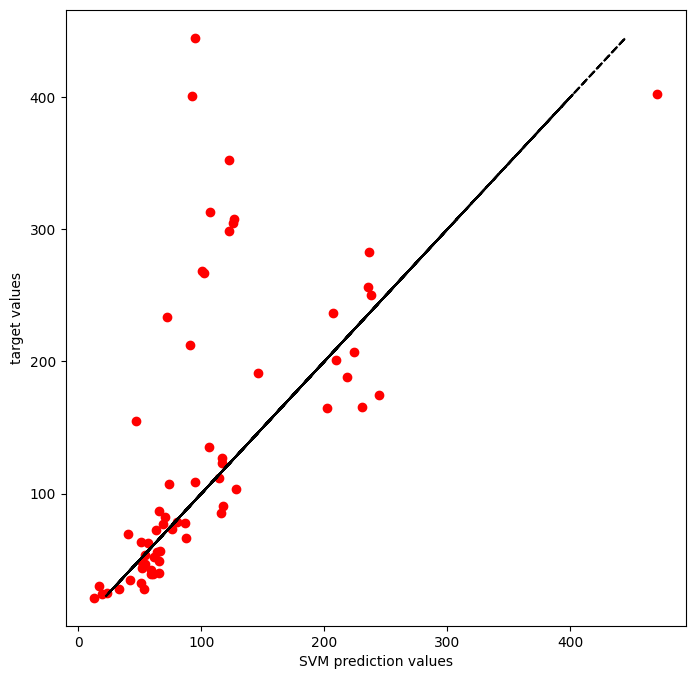

In [64]:
# 评估SVM方法的结果
r2_svm = r2_score(Y_test, Y_pred_svm)
print("SVM R2 Score:", r2_svm)

# 绘图
plt.figure(figsize=(8, 8)) 
      
# 将预测值pt作为x轴，目标值tgt作为y轴，绘制散点图，散点越接近y=x直线表明结果越准确
plt.scatter(Y_pred_svm, Y_test, color='red')
    
# 绘制y=x直线作为参考
plt.plot(Y_test, Y_test, color='black', linestyle='dashed')
plt.xlabel('SVM prediction values')
plt.ylabel('target values')
plt.show()

In [65]:
len(Y_train)

576

In [104]:
########### 以下利用深度神经网络预测 ############
# 划分数据，训练集每64个一组，测试集分为两组
TRAIN_BATCH_SIZE = 64


# 利用random.shuffle打乱数据以保证随机性
indices = torch.randperm(len(srcs))
srcs, tgts = srcs[indices], tgts[indices]

# 划分训练集和测试集
src_train_data, src_test_data = srcs[:TRAIN_SIZE], srcs[-TEST_SIZE:]
tgt_train_data,  tgt_test_data = tgts[:TRAIN_SIZE], tgts[-TEST_SIZE:]
train_data = TensorDataset(src_train_data, tgt_train_data)
test_data = TensorDataset(src_test_data, tgt_test_data)
TEST_BATCH_SIZE = len(test_data)

# 请查询DataLoader的使用方法，用于分批加载数据
# 一般而言，总数据量远超计算内存，因此需要分批加载进行训练，也有助于梯度下降
##### your code here ##### 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2
)
print(f"训练数据集批次: {len(train_loader)}，每批数据量 {TRAIN_BATCH_SIZE}")
print(f"测试数据集批次: {len(test_loader)}，每批数据量 {TEST_BATCH_SIZE}")

训练数据集批次: 10，每批数据量 64
测试数据集批次: 1，每批数据量 32


In [105]:
# 神经网络模型实现
class beamNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1, activation=nn.ReLU()):
        """
        在这里初始化模型，结构为线性层+激活函数
        参数：
            src_size(int):输入特征维度
            hidden_size(int):模型的隐层维度
            tgt_size(int):输出特征维度
            num_layers(int):模型的线性层数，可取3~5
            dropout(int):dropout模块,用于防止过拟合，一般取0~0.1
            activation(nn.Module):激活函数，默认选择nn.ReLU()即可
        提示：
            可调用pytorch的nn.Linear模块搭建线性层
        """
        super().__init__()
        # 定义第一层（从输入层到隐藏层）
        self.fc1 = nn.Linear(input_size, hidden_size)
        # 定义第二层（从隐藏层到输出层）
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        ##### your code here #####
        
 
    def forward(self, src):
        """
        在这里定义模型的forward函数
        参数：
            src(torch.Tensor):分批次的输入张量，初始形状需为[batch_size, src_size]，其中
            batch_size:输入每个batch的size
            src_size:输入特征维度
        输出：
            output(torch.Tensor):形状应为[batch_size, tgt_size]
        """
        ##### your code here #####
        x = torch.relu(self.fc1(src))
        x = torch.relu(self.fc2(x))
        # 应用第二层
        x = self.fc3(x)
        return x

In [106]:
# 定义训练函数
def train(model, data_loader, num_epochs, num_log):
    """
    在这里定义一个训练模块函数
    参数：
        model(nn.Module):模型
        data_loader(DataLoader):用于加载训练数据的loader
        optimizer:训练的优化器
        lr_scheduler: 训练learning rate的调整器
        criterion:计算loss的损失函数
        num_epochs:训练的轮次（所有数据训练一遍作为一轮）
        num_log: 每隔num_log个batch输出当前的训练loss
    输出：
        train_loss(list[float]):记录每个step的训练loss的列表
    提示：
        对轮次进行循环，每个轮次对数据批次进行循环
    """
    model.train()
    train_loss = []
    
    import torch.optim as optim
    from torch.optim.lr_scheduler import StepLR
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = StepLR(optimizer, step_size=500, gamma=0.5)
    for epoch in range(num_epochs):
        for batch_idx, (src, tgt) in enumerate(data_loader):
            # 加载数据，src作为src, tgt作为tgt
            # 这里.to(device)主要适用于如果有gpu计算的情况，需要放到gpu上
            src, tgt = src.to(device), tgt.to(device) 
            #prediction = ?
            
            # 计算loss并反向传播梯度
            #loss = ?
            ##### your code here #####
            #train_loss.append(loss.item())
            
            optimizer.zero_grad()
            outputs = model(src)
            loss = criterion(outputs, tgt)
            loss.backward()
            train_loss.append(loss.item())
            optimizer.step()
            lr_scheduler.step()
            
            # 输出当前训练状态
            if len(train_loss) % num_log == 0:
                print(f'[Epoch: {epoch + 1}] [Batch idx: {batch_idx + 1}] train loss: {loss.item():.4f}' )
    return train_loss

In [69]:
#HIDDEN_SIZE = ?
#NUM_LAYERS = ?
DROP_OUT = 0.05

# 模型的保存路径
SAVE_NAME = 'beamnn_params.pt'

# 初始化训练参数，可以根据训练效果调整
NUM_EPOCHS = 100                # 迭代次数，建议100次以上
TOTAL_STEPS = TRAIN_SIZE // TRAIN_BATCH_SIZE * NUM_EPOCHS
STEP_SIZE = TOTAL_STEPS // 4
LR = 0.001                       # 初始学习率，建议0.0001~0.001

# 初始化model和optimizer
# 选择MSELoss作为criterion(其他度量也可)
# 选择nn.ReLU()作为激活函数
# 选择lr_scheduler.StepLR作为lr_scheduler，设置step_size=STEP_SIZE
# 如果有gpu，注意放到gpu上进行计算
##### your code here #####
#activation = ?
model = beamNN(8)
##### 如果有gpu，注意放到gpu上进行计算 #####
model.to(device)
#optimizer = ?
#criterion = ?
#lr_scheduler = ?

# 输出
NUM_LOG = TOTAL_STEPS // 20
print(f"总训练轮次: {NUM_EPOCHS}, 总训练步数: {TRAIN_SIZE//TRAIN_BATCH_SIZE * NUM_EPOCHS}")
print(f"学习率每{STEP_SIZE}步进行调整, 每{NUM_LOG}步输出当前loss")

总训练轮次: 100, 总训练步数: 900
学习率每225步进行调整, 每45步输出当前loss


device(type='cuda', index=0)

In [70]:
# 进行训练并保存结果
# 根据配置和训练参数，训练需要1-15分钟，若时间过长可调大batch_size,减小epochs
train_loss = train(model,train_loader,NUM_EPOCHS,10)
torch.save(model.state_dict( ), SAVE_NAME)

[Epoch: 1] [Batch idx: 10] train loss: 0.0220
[Epoch: 2] [Batch idx: 10] train loss: 0.0312
[Epoch: 3] [Batch idx: 10] train loss: 0.0041
[Epoch: 4] [Batch idx: 10] train loss: 0.0066
[Epoch: 5] [Batch idx: 10] train loss: 0.0097
[Epoch: 6] [Batch idx: 10] train loss: 0.0073
[Epoch: 7] [Batch idx: 10] train loss: 0.0054
[Epoch: 8] [Batch idx: 10] train loss: 0.0057
[Epoch: 9] [Batch idx: 10] train loss: 0.0083
[Epoch: 10] [Batch idx: 10] train loss: 0.0104
[Epoch: 11] [Batch idx: 10] train loss: 0.0211
[Epoch: 12] [Batch idx: 10] train loss: 0.0089
[Epoch: 13] [Batch idx: 10] train loss: 0.0037
[Epoch: 14] [Batch idx: 10] train loss: 0.0175
[Epoch: 15] [Batch idx: 10] train loss: 0.0034
[Epoch: 16] [Batch idx: 10] train loss: 0.0252
[Epoch: 17] [Batch idx: 10] train loss: 0.0092
[Epoch: 18] [Batch idx: 10] train loss: 0.0066
[Epoch: 19] [Batch idx: 10] train loss: 0.0037
[Epoch: 20] [Batch idx: 10] train loss: 0.0059
[Epoch: 21] [Batch idx: 10] train loss: 0.0052
[Epoch: 22] [Batch idx

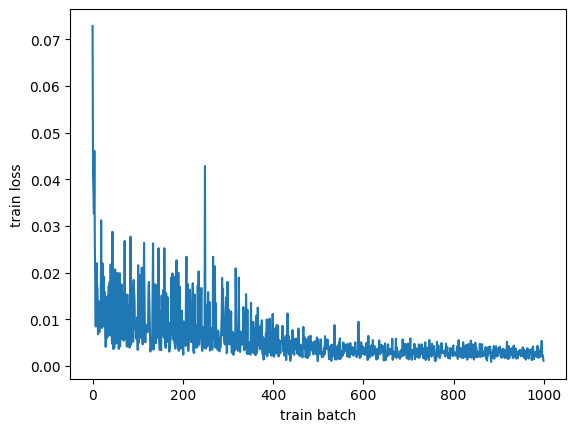

In [71]:
# 绘制训练过程的loss变化情况，一般是迅速下降-缓慢下降-收敛的曲线
plt.plot(train_loss)
plt.xlabel('train batch')
plt.ylabel('train loss')
plt.show()

In [109]:
# 定义测试函数
def test(model, data_loader):
    """
    在这里定义一个测试模块函数
    参数：
        model(nn.Module):模型
        data_loader(DataLoader):用于加载测试数据的loader
        criterion:评估测试结果的损失函数
    输出：
        eval_loss(list[float]):记录每批次测试数据的评估loss的列表
        results(list[(src, tgt, pt)]):一个列表，其中每个元素记录一个批次的src,tgt,pt，pt表示prediction
    提示：
       对数据批次进行循环
    """
    model.eval()
    eval_loss = []
    results = []
    criterion = nn.MSELoss()
    
    for batch_idx, (src, tgt) in enumerate(data_loader):
        ##### your code here #####
        
        outputs = model(src)
        loss = criterion(outputs, tgt)
        print(tgt.shape)
        # prediction = model.forward(src)
        eval_loss.append(loss.item())
        results.append((src, tgt, outputs))
        # 输出当前评估结果
        print(f'[Batch idx: {batch_idx + 1}] eval loss: {loss.item():.4f}' )
        
    return eval_loss, results

In [110]:
# 加载训练的模型进行评估
model.to(device)
saved_dict = torch.load(SAVE_NAME)
model.load_state_dict(saved_dict)
eval_loss, results = test(model, test_loader)

C:\Users\65197\AppData\Local\Temp\ipykernel_11468\3433947477.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(SAVE_NAME)


torch.Size([32, 1])
[Batch idx: 1] eval loss: 0.0015


In [111]:
# 绘制测试集结果的散点图
plt.figure(figsize=(8,8))
src, tgt, pt = results[0]
print(pt.shape)
tgt = data_postprocess(tgt, tgt_ref)
pt = data_postprocess(pt,tgt_ref)
# 转化成numpy的array方便绘图
tgt = tgt[:, 0].cpu().numpy()
pt = pt[:, 0].detach().cpu().numpy()

torch.Size([32, 1])


<Figure size 800x800 with 0 Axes>

In [112]:
tgt.shape

(32,)

In [113]:
pt.shape

(32,)

nn Score:  0.6908905506134033


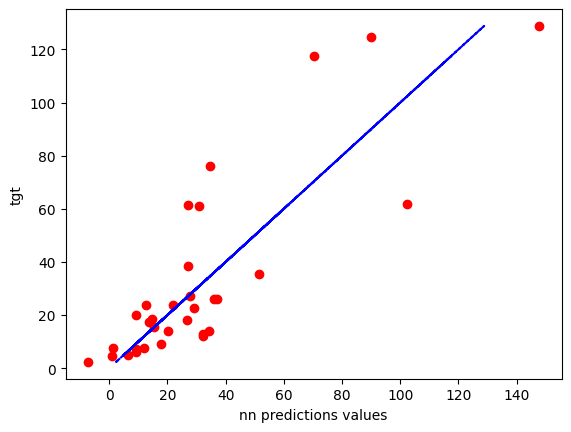

In [114]:
plt.scatter(pt, tgt, color='red')
r2_nn = r2_score(tgt, pt)
print("nn Score: ", r2_nn)

plt.plot(tgt, tgt, color='blue', linestyle='--')
plt.xlabel('nn predictions values')
plt.ylabel('tgt')
plt.show()
# 绘图
##### your code here #####

# 更多思考
请思考并试验以下因素对模型效果的影响，尝试进一步优化模型:

1、数据方面：数据选取，数据量，数据集划分，选取的特征，数据预处理方法等

2、模型方面：机器学习方法和深度学习方法预测结果的差异？对于深度神经网络，考虑模型参数（hidden_size)，模型层数（num_layers)，模型结构，是否有线性层，激活函数等因素

3、训练方面：每批数据量（batch_size），训练轮次（num_epochs)，初始学习率（LR)，学习率调整策略，优化器选择等；为什么在训练集上Loss已经足够低了，在测试集上仍然有可见的偏差？

4、力学方面：结合预测和理论结果的差异，分析如何使模型更好地模拟力学行为。

欢迎各位保持交流，谢谢！